# Import data

In [9]:
import pandas as pd

# Read all sheets into a dictionary of DataFrames
# dfs = pd.read_excel('experiment-a-b.xlsx', sheet_name=None)
dfs = pd.read_excel('result_abcd.xlsx', sheet_name=None)


# Print the names of the sheets
print(dfs.keys())

dict_keys(['Δ𝜂 > 0 in X', 'Δ𝜂 < 0 in X', 'Δ𝜂 > 0 in 𝑝0', 'Δ𝜂 < 0 in 𝑝0'])


# Helper functions

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Set default figure size (width, height in inches)
plt.rcParams['figure.figsize'] = [4, 3]
# plt.rcParams['figure.figsize'] = [8, 6]

plt.rcParams['font.size'] = 16

plt.rcParams['lines.markersize'] = 10  # Default marker size is 6

In [121]:
VERBOSE = False

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorMap = {
    "batch": colors[1],
    "IncMiner": colors[0],
    "IncMinerT": colors[6],
    "IncMinerNS": colors[4],
    "IncMinerNoO": colors[2],
    "IApriori": colors[3],
    "DCFinder": colors[5]
}

markerMap = {
    "batch": '^',
    "IncMiner": 's',
    "IncMinerT": 'o',
    "IncMinerNS": '*',
    "IncMinerNoO": 'v',
    "IApriori": '+',
    "DCFinder": 'x'
}

legendName = {
    "batch": "BatchMiner",
    "IncMiner": r"$IncMiner_\Omega$",
    "IncMinerT": r"$IncMiner_\Theta$",
    "IncMinerNS": r"$IncMiner_{NS}$",
    "IncMinerNoO": r"$IncMiner_{NoO}$",
    "IApriori": r"$IApriori_\Theta$",
    "DCFinder": "DCFinder"
}

markerStyleMap = {
    "batch": {'markerfacecolor': 'none', 'markeredgewidth': 1.0},
    "IncMiner": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
    "IncMinerT": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
    
    "IncMinerNS": {'markerfacecolor': 'none', 'markeredgewidth': 1.0, 'markersize':10},
    "IncMinerNoO": {'markerfacecolor': 'none', 'markeredgewidth': 1.0, 'markersize':10},
    "IApriori": {'markerfacecolor': 'auto', 'markeredgewidth': 1.5},
    "DCFinder": {'markerfacecolor': 'auto', 'markeredgewidth': 1.0},
}


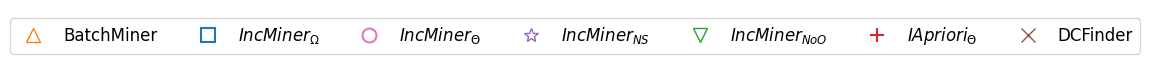

In [3]:
# Create legend elements, skipping "IncMiner1.0"
legend_elements = [
    plt.Line2D([0], [0], color=colorMap[label], marker=markerMap[label], 
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
               linestyle='', label=legendName[label])
    for label in colorMap.keys() if label != "IncMiner1.0"
]

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 1))  # Adjust width and height for a wide flat layout

# Remove axes
ax.axis('off')

# Add the legend
ax.legend(
    handles=legend_elements,
    loc='center',
    frameon=True,
    fontsize=12,
    ncol=len(legend_elements),  # Arrange all legend entries in a single row
)

# Adjust layout
plt.tight_layout()

# Save or display the legend-only plot
plt.savefig("plots/legend.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [4]:
ylabel_time = "Running time (s)"

In [5]:
def post_process(_df):
    # 1. Compute scale factor of 'new support' over 'old support'
    _df['supportScale'] = _df['new support'] / _df['old support']

    # 2. Compute absolute difference of 'new confidence' over 'old confidence'
    _df['confDiff'] = _df['new confidence'] - _df['old confidence']
    
    # 4. Convert Mining time scale, but leave as is if 'timeout'
    _df['time'] = _df['Mining time'].apply(
        lambda x: max(x,1000) / 1000 if isinstance(x, (int, float)) else x
    )

    return _df

In [6]:
def compute_speedup(df, baseline_label, target_labels, metric="time"):
    """
    Compute the maximal and average speedup for target labels compared to a baseline label,
    replacing zero values with 1 to avoid division errors.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing timing data.
        baseline_label (str): The label of the baseline group (e.g., 'batch').
        target_labels (list): A list of labels for the groups to compare against the baseline.
    
    Returns:
        dict: A dictionary with the speedup results for each target label.
    """
    # Group by the "label" column
    groups = df.groupby('Baseline')
    
    # Extract baseline times
    if baseline_label not in groups.groups:
        raise ValueError(f"Baseline label '{baseline_label}' not found in data.")
    
    # times_baseline = groups.get_group(baseline_label)['time'].replace(0, 1).values  # Replace 0 with 1
    times_baseline = groups.get_group(baseline_label)[metric].apply(lambda x: max(x, 1)).values  # Replace values < 1 with 1

    
    # Initialize results dictionary
    speedup_results = {}
    
    # Compute speedup for each target label
    for label in target_labels:
        if label not in groups.groups:
            print(f"Warning: Target label '{label}' not found in data. Skipping.")
            continue
        
        # times_target = groups.get_group(label)['time'].replace(0, 1).values  # Replace 0 with 1
        times_target = groups.get_group(label)[metric].apply(lambda x: max(x, 1)).values  # Replace values < 1 with 1

        
        # Ensure the baseline and target have the same number of entries
        if len(times_baseline) != len(times_target):
            raise ValueError(f"Mismatch in number of entries for baseline '{baseline_label}' and target '{label}'.")
        
        # Calculate speedup
        speedups = times_baseline / times_target
        
        # Store results
        speedup_results[label] = {
            "max_speedup": speedups.max(),
            "avg_speedup": speedups.mean()
        }
    
    return speedup_results

# Exp-1-a

In [7]:
def pre_process_exp1(_df):
    # 1. Compute scale factor of 'new support' over 'old support'
    _df['etaDiff'] = _df['new eta'] - _df['old eta']

    # 4. Convert Mining time scale, but leave as is if 'timeout'
    _df['time'] = _df['Mining time'].apply(
        lambda x: max(x,1000) / 1000 if isinstance(x, (int, float)) else x
    )

    return _df

In [239]:
tab = 'Δ𝜂 > 0 in X'
df = dfs[tab]
df = pre_process_exp1(df)

IncMiner
IncMinerNS
IncMinerNoO
batch


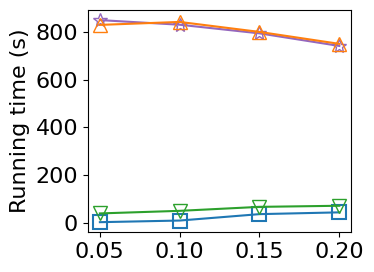

In [240]:

# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis

xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_hospital_eta_X_increase.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_20535/2693887170.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group['time'].apply(


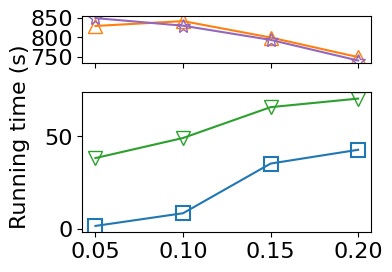

{'IncMiner': {'max_speedup': np.float64(511.76481481481477),
  'avg_speedup': np.float64(162.79907186088158)}}

In [241]:
# Group by the "label" column
groups = df.groupby('Baseline')

# # Create a figure with two subplots (vertically stacked)
# fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)
# Create subplots with adjusted heights
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1,  # Two subplots stacked vertically
    sharex=True,
    gridspec_kw={'height_ratios': [1, 3]}  # Set the relative heights
)


top_labels = ['batch', 'IncMinerNS']
bottom_labels = ['IncMiner', 'IncMinerNoO']

# Calculate the global maximum value of numeric 'time' across all groups
global_max_time = df['time'][pd.to_numeric(df['time'], errors='coerce').notna()].max()
timeout_value = global_max_time*1.1

# Plot for labels in the top box
for label in top_labels:
    group = groups.get_group(label)
    # Replace 'timeout' with a placeholder value at the top of the y-axis
    group['time'] = group['time'].apply(
        lambda x: timeout_value if x == 'timeout' else x
    )
    Y = group['time']
    ax_top.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )
    
    # Add 'TO' tick to the top subplot
    # ax_top.set_yticks(list(ax_top.get_yticks())[:1] + [timeout_value])  # Add timeout_value to y-ticks
    # ax_top.set_yticklabels([str(int(tick)) if tick != timeout_value else 'TO' for tick in ax_top.get_yticks()[:2]])

# Plot for other labels in the bottom box
for label in bottom_labels:
    group = groups.get_group(label)
    Y = group['time']
    ax_bottom.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )


xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

fig.text(0.01, 0.5, ylabel_time, va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()

# Save the plot
outfile = "plots/exp1_hospital_eta_X_increase.pdf"
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner'])

## exp1-b

In [242]:
tab = 'Δ𝜂 < 0 in X'
df = dfs[tab]
df = pre_process_exp1(df)

IncMiner
IncMinerNS
IncMinerNoO
batch


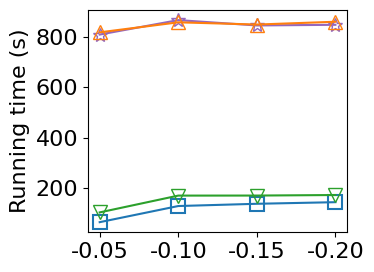

In [243]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis

xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_hospital_eta_X_decrease.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_20535/1938494635.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group['time'].apply(


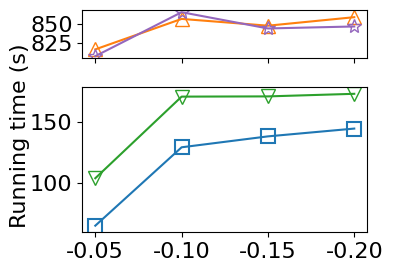

{'IncMiner': {'max_speedup': np.float64(12.454660506533704),
  'avg_speedup': np.float64(7.782798326674769)}}

In [244]:
# Group by the "label" column
groups = df.groupby('Baseline')

# # Create a figure with two subplots (vertically stacked)
# fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)
# Create subplots with adjusted heights
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1,  # Two subplots stacked vertically
    sharex=True,
    gridspec_kw={'height_ratios': [1, 3]}  # Set the relative heights
)


top_labels = ['batch', 'IncMinerNS']
bottom_labels = ['IncMiner', 'IncMinerNoO']

# Calculate the global maximum value of numeric 'time' across all groups
global_max_time = df['time'][pd.to_numeric(df['time'], errors='coerce').notna()].max()
timeout_value = global_max_time*1.1

# Plot for labels in the top box
for label in top_labels:
    group = groups.get_group(label)
    # Replace 'timeout' with a placeholder value at the top of the y-axis
    group['time'] = group['time'].apply(
        lambda x: timeout_value if x == 'timeout' else x
    )
    Y = group['time']
    ax_top.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )
    
    # Add 'TO' tick to the top subplot
    # ax_top.set_yticks(list(ax_top.get_yticks())[:1] + [timeout_value])  # Add timeout_value to y-ticks
    # ax_top.set_yticklabels([str(int(tick)) if tick != timeout_value else 'TO' for tick in ax_top.get_yticks()[:2]])

# Plot for other labels in the bottom box
for label in bottom_labels:
    group = groups.get_group(label)
    Y = group['time']
    ax_bottom.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )


# xtick_labels = [fr"$\times 10^{{{int(np.log10(value))}}}$" for value in X]
xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

fig.text(0.01, 0.5, ylabel_time, va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()

# Save the plot
outfile = "plots/exp1_hospital_eta_X_decrease.pdf"
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner'])

## exp1-c

In [245]:
tab = 'Δ𝜂 > 0 in 𝑝0'
df = dfs[tab]
df = pre_process_exp1(df)

IncMiner
IncMinerNS
IncMinerNoO
batch


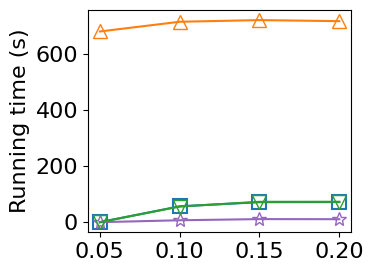

In [246]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis

xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_hospital_eta_p_increase.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_20535/1886101312.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group['time'].apply(


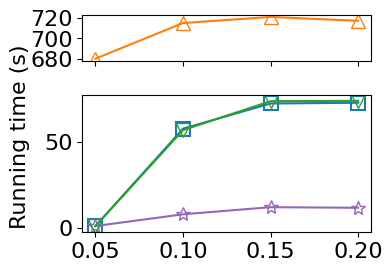

{'IncMiner': {'max_speedup': np.float64(680.151),
  'avg_speedup': np.float64(178.10873772392014)}}

In [247]:
# Group by the "label" column
groups = df.groupby('Baseline')

# # Create a figure with two subplots (vertically stacked)
# fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)
# Create subplots with adjusted heights
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1,  # Two subplots stacked vertically
    sharex=True,
    gridspec_kw={'height_ratios': [1, 3]}  # Set the relative heights
)


top_labels = ['batch']
bottom_labels = ['IncMiner', 'IncMinerNS', 'IncMinerNoO']

# Calculate the global maximum value of numeric 'time' across all groups
global_max_time = df['time'][pd.to_numeric(df['time'], errors='coerce').notna()].max()
timeout_value = global_max_time*1.1

# Plot for labels in the top box
for label in top_labels:
    group = groups.get_group(label)
    # Replace 'timeout' with a placeholder value at the top of the y-axis
    group['time'] = group['time'].apply(
        lambda x: timeout_value if x == 'timeout' else x
    )
    Y = group['time']
    ax_top.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )
    
    # Add 'TO' tick to the top subplot
    # ax_top.set_yticks(list(ax_top.get_yticks())[:1] + [timeout_value])  # Add timeout_value to y-ticks
    # ax_top.set_yticklabels([str(int(tick)) if tick != timeout_value else 'TO' for tick in ax_top.get_yticks()[:2]])

# Plot for other labels in the bottom box
for label in bottom_labels:
    group = groups.get_group(label)
    Y = group['time']
    ax_bottom.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )


# xtick_labels = [fr"$\times 10^{{{int(np.log10(value))}}}$" for value in X]
xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

fig.text(0.01, 0.5, ylabel_time, va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()

# Save the plot
outfile = "plots/exp1_hospital_eta_p_increase.pdf"
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner'])

## exp1-d

In [248]:
tab = 'Δ𝜂 < 0 in 𝑝0'
df = dfs[tab]
df = pre_process_exp1(df)

IncMiner
IncMinerNS
IncMinerNoO
batch


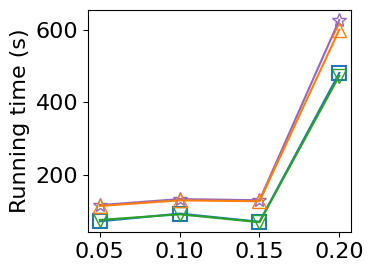

In [274]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis

xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_hospital_eta_p_decrease.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_20535/107028666.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group['time'].apply(


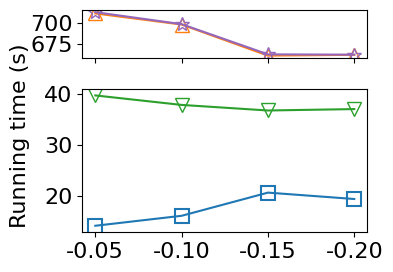

{'IncMiner': {'max_speedup': np.float64(50.70693831030061),
  'avg_speedup': np.float64(40.193506771245936)}}

In [250]:
# Group by the "label" column
groups = df.groupby('Baseline')

# # Create a figure with two subplots (vertically stacked)
# fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)
# Create subplots with adjusted heights
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1,  # Two subplots stacked vertically
    sharex=True,
    gridspec_kw={'height_ratios': [1, 3]}  # Set the relative heights
)


top_labels = ['batch', 'IncMinerNS']
bottom_labels = ['IncMiner', 'IncMinerNoO']

# Calculate the global maximum value of numeric 'time' across all groups
global_max_time = df['time'][pd.to_numeric(df['time'], errors='coerce').notna()].max()
timeout_value = global_max_time*1.1

# Plot for labels in the top box
for label in top_labels:
    group = groups.get_group(label)
    # Replace 'timeout' with a placeholder value at the top of the y-axis
    group['time'] = group['time'].apply(
        lambda x: timeout_value if x == 'timeout' else x
    )
    Y = group['time']
    ax_top.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )
    
    # Add 'TO' tick to the top subplot
    # ax_top.set_yticks(list(ax_top.get_yticks())[:1] + [timeout_value])  # Add timeout_value to y-ticks
    # ax_top.set_yticklabels([str(int(tick)) if tick != timeout_value else 'TO' for tick in ax_top.get_yticks()[:2]])

# Plot for other labels in the bottom box
for label in bottom_labels:
    group = groups.get_group(label)
    Y = group['time']
    ax_bottom.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )


# xtick_labels = [fr"$\times 10^{{{int(np.log10(value))}}}$" for value in X]
xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

fig.text(0.01, 0.5, ylabel_time, va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()

# Save the plot
outfile = "plots/exp1_hospital_eta_p_decrease.pdf"
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner'])

# Exp-1-e


In [122]:
# dfs = pd.read_excel('result_e-j.xlsx', sheet_name=None)
# dfs = pd.read_excel('result_实验e-j_0716.xlsx', sheet_name=None)
dfs = pd.read_excel('result_实验e-j_0717.xlsx', sheet_name=None)
print(dfs.keys())

dict_keys(['ΔΩ > 0', 'ΔΩ < 0', 'ΔΩ > 0, Δ𝜎 > 0, Δ𝛿 > 0', 'ΔΩ < 0, Δ𝜎 < 0, Δ𝛿 < 0', 'ΔΩ > 0, Δ𝜎 < 0, Δ𝛿 < 0', 'ΔΩ < 0, Δ𝜎 > 0, Δ𝛿 > 0'])


In [123]:
tab = 'ΔΩ > 0'
df = dfs[tab]
df = pre_process_exp1(df)
df = post_process(df)
df = df.dropna(subset=['time'])

IncMiner
IncMinerNS
IncMinerNoO
batch


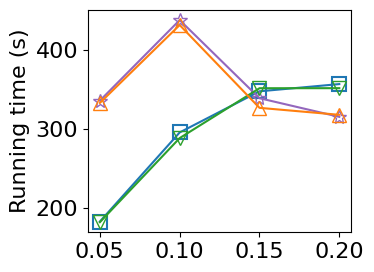

{'IncMiner': {'max_speedup': np.float64(1.8158497355651275),
  'avg_speedup': np.float64(1.2763014724193433)}}

In [124]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis


# xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_omega>0.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 


# Compute speedup
compute_speedup(df, 'batch', ['IncMiner'])

## Exp1-f

In [125]:
tab = 'ΔΩ < 0'
df = dfs[tab]
df = pre_process_exp1(df)
df = post_process(df)
df = df.dropna(subset=['time'])

IncMiner
IncMinerNS
IncMinerNoO
batch


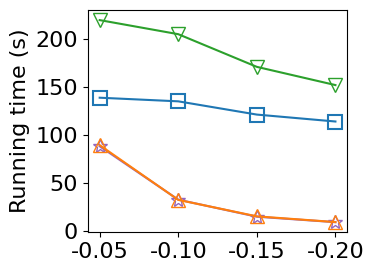

{'IncMiner': {'max_speedup': np.float64(0.6452863296728586),
  'avg_speedup': np.float64(0.2754117793700587)}}

In [135]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis


# xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
xtick_labels = [f"{value:.2f}" for value in X]
plt.xticks(range(len(X)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_omega<0.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

compute_speedup(df, 'batch', ['IncMiner'])

# Exp1-g

In [127]:
tab = 'ΔΩ > 0, Δ𝜎 > 0, Δ𝛿 > 0'
df = dfs[tab]
df = pre_process_exp1(df)
df = post_process(df)
df = df.dropna(subset=['time'])

IncMiner
IncMinerNS
IncMinerNoO
batch


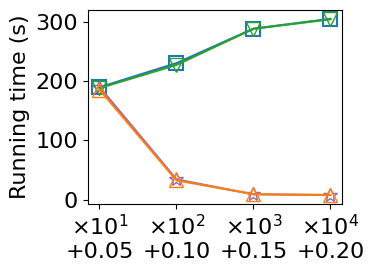

In [128]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis


xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_omega+_p+.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

## Exp1-h

In [140]:
tab = 'ΔΩ < 0, Δ𝜎 < 0, Δ𝛿 < 0'
df = dfs[tab]
df = pre_process_exp1(df)
df = post_process(df)
df = df.dropna(subset=['time'])

IncMiner
IncMinerNS
IncMinerNoO
batch


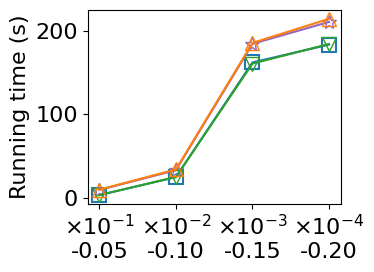

{'IncMiner': {'max_speedup': np.float64(2.9578947368421056),
  'avg_speedup': np.float64(1.6597657198602571)}}

In [141]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis


xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_omega-_p-.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

compute_speedup(df, 'batch', ['IncMiner'])

## Exp1-i

In [139]:
tab = 'ΔΩ > 0, Δ𝜎 < 0, Δ𝛿 < 0'
df = dfs[tab]
df = pre_process_exp1(df)
df = post_process(df)
df = df.dropna(subset=['time'])

IncMiner
IncMinerNS
IncMinerNoO
batch


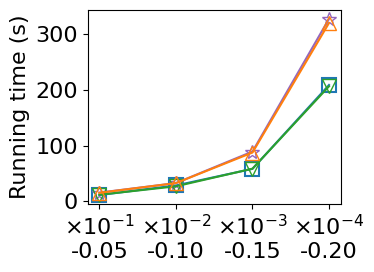

{'IncMiner': {'max_speedup': np.float64(1.5329645593869732),
  'avg_speedup': np.float64(1.386414898514647)}}

In [132]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis


xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_omega+_p-.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

compute_speedup(df, 'batch', ['IncMiner'])

## exp1-j

In [133]:
tab = 'ΔΩ < 0, Δ𝜎 > 0, Δ𝛿 > 0'
df = dfs[tab]
df = pre_process_exp1(df)
df = post_process(df)
df = df.dropna(subset='time')

IncMiner
IncMinerNS
IncMinerNoO
batch


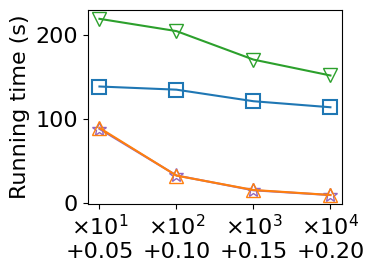

In [134]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['etaDiff']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis

xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_omega-_p+.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

# Exp-2

In [285]:
# Read all sheets into a dictionary of DataFrames
dfs = pd.read_excel('result_vary_n_hospital.xlsx', sheet_name=None)


# Print the names of the sheets
print(dfs.keys())

dict_keys(['vary n'])


In [286]:
df = dfs['vary n']
df = pre_process_exp1(df)

IncMiner
IncMinerNS
IncMinerNoO
batch


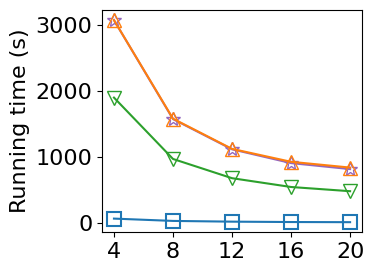

In [287]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['worker instances']
    # print (group['time'])
    plt.plot(X, group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis

xtick_labels = [str(value) for value in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp2_hospital_vary_n.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

batch 3.642019721191332
IncMinerNS 3.7428820258591813
IncMinerNoO 3.9072659354568278
IncMiner 3.9033611185802637


/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_20535/1197542340.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group['time'].apply(


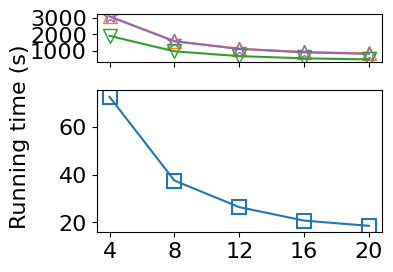

{'IncMiner': {'max_speedup': np.float64(45.37031460069911),
  'avg_speedup': np.float64(43.45923054412942)}}

In [288]:
# Group by the "label" column
groups = df.groupby('Baseline')

# # Create a figure with two subplots (vertically stacked)
# fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)
# Create subplots with adjusted heights
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1,  # Two subplots stacked vertically
    sharex=True,
    gridspec_kw={'height_ratios': [1, 3]}  # Set the relative heights
)


top_labels = ['batch', 'IncMinerNS', 'IncMinerNoO']
bottom_labels = ['IncMiner']

# Calculate the global maximum value of numeric 'time' across all groups
global_max_time = df['time'][pd.to_numeric(df['time'], errors='coerce').notna()].max()
timeout_value = global_max_time*1.1

# Plot for labels in the top box
for label in top_labels:
    group = groups.get_group(label)
    # Replace 'timeout' with a placeholder value at the top of the y-axis
    group['time'] = group['time'].apply(
        lambda x: timeout_value if x == 'timeout' else x
    )
    X = group['worker instances']
    Y = group['time']
    print(label, max(Y)/min(Y))
    ax_top.plot(
        X, group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )
    
    # Add 'TO' tick to the top subplot
    # ax_top.set_yticks(list(ax_top.get_yticks())[:1] + [timeout_value])  # Add timeout_value to y-ticks
    # ax_top.set_yticklabels([str(int(tick)) if tick != timeout_value else 'TO' for tick in ax_top.get_yticks()[:2]])

# Plot for other labels in the bottom box
for label in bottom_labels:
    group = groups.get_group(label)
    X = group['worker instances']
    Y = group['time']
    print(label, max(Y)/min(Y))
    ax_bottom.plot(
        X, group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )


xtick_labels = [str(value) for value in X]
plt.xticks(X, xtick_labels)

fig.text(0.01, 0.5, ylabel_time, va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()

# Save the plot
outfile = "plots/exp2_hospital_vary_n.pdf"
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner'])

# Exp-3

In [290]:
dfs = pd.read_excel('result_vary_s.xlsx', sheet_name=None)
print(dfs.keys())

dict_keys(['vary |S|'])


In [291]:
df = dfs['vary |S|']
df = pre_process_exp1(df)

IncMiner


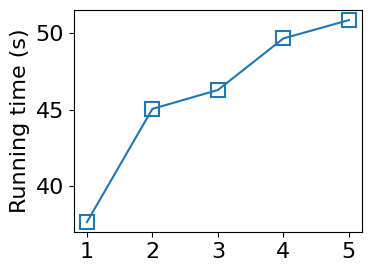

In [292]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['K']
    # print (group['time'])
    plt.plot(X, group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis

xtick_labels = [str(value) for value in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp3_hospital_s_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 

IncMiner


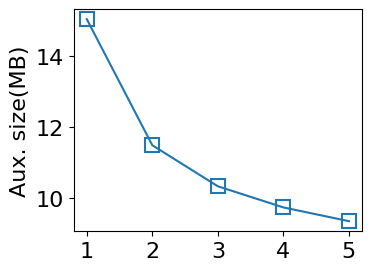

In [296]:
# Group by the "label" column
groups = df.groupby('Baseline')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['K']
    # print (group['time'])
    plt.plot(X, # group['sample number'], 
                group['auxiliary size(MB)'],
             label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)
            ) 
    
# Add plot labels and legend
# plt.ylabel('# Samples')  # Label for y-axis
plt.ylabel('Aux. size(MB)')  # Label for y-axis

xtick_labels = [str(value) for value in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.xlabel('delta eta')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp3_hospital_s_size.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show() 